In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture

07.06.2022 10:42:12 Creating Training Directory at 2022-06-07_10-42_MinCut_CG_Classifier/
07.06.2022 10:42:14 Loading Datasets
07.06.2022 10:42:14 Start Training


Epoch 0: Training loss 10.8764; Validation loss 14.6795, MAE: 14.9375; lr: 0.00100
	Add. Loss: Training 0.2535, Validation 0.2323
Epoch 5: Training loss 4.8902; Validation loss 15.6025, MAE: 15.8613; lr: 0.00100
	Add. Loss: Training 0.2367, Validation 0.2352
Epoch 10: Training loss 3.5053; Validation loss 15.7811, MAE: 16.0450; lr: 0.00100
	Add. Loss: Training 0.2378, Validation 0.2341
Epoch 15: Training loss 3.2680; Validation loss 15.1694, MAE: 15.4359; lr: 0.00100
	Add. Loss: Training 0.2385, Validation 0.2296
Epoch 20: Training loss 2.6312; Validation loss 15.3261, MAE: 15.5881; lr: 0.00100
	Add. Loss: Training 0.2347, Validation 0.2300
Epoch 25: Training loss 2.2869; Validation loss 14.8183, MAE: 15.0675; lr: 0.00100
	Add. Loss: Training 0.2415, Validation 0.2381
Epoch 30: Training loss 1.8810; Validation loss 14.8034, MAE: 15.0577; lr: 0.00100
	Add. Loss: Training 0.2363, Validation 0.2355
Epoch 35: Training loss 1.8116; Validation loss 14.7742, MAE: 15.0262; lr: 0.00100
	Add. Lo

07.06.2022 11:44:18 Training took 1.04 hours
07.06.2022 11:44:18 Minimum Training Loss -0.7700 in epoch 7997
07.06.2022 11:44:18 Minimum Validation Loss (after 100 epochs) 12.1707 in epoch 7314
07.06.2022 11:44:18 Minimum MAE (after 100 epochs) 13.2058 in epoch 7314
07.06.2022 11:44:18 Seed used for training was: 12075733730554211235


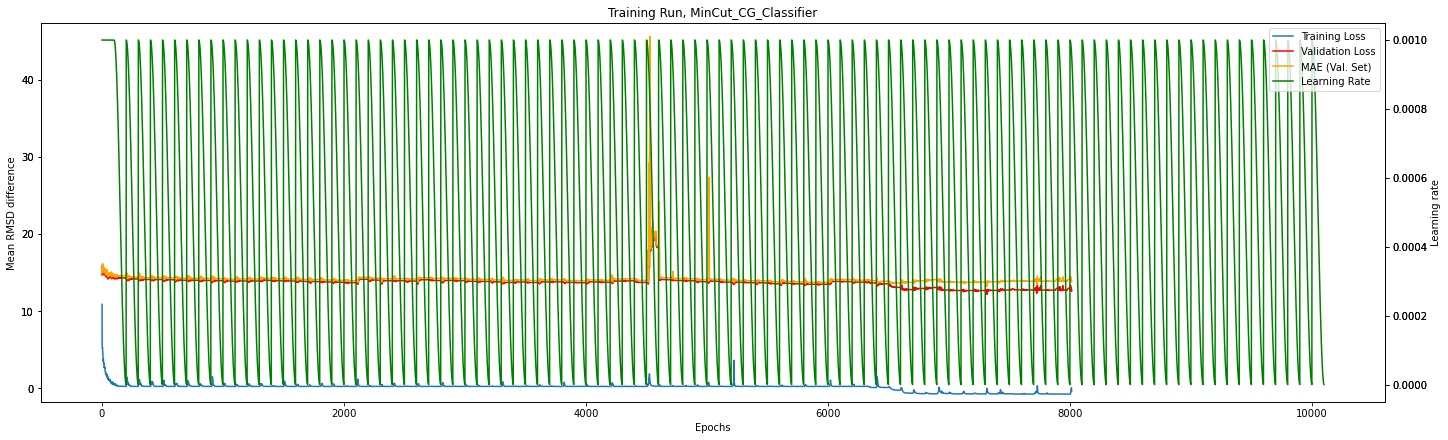

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=10_000,
    sched_T0=100,
    vectorize=vectorize,
    k=k,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=100)

In [3]:
#get training run data

run_dir = "run_data/2022-06-07_10-42_MinCut_CG_Classifier"
burn_in = 100

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss -0.7700 in epoch 7997
Minimum Validation Loss (after 100 epochs) 12.1707 in epoch 7314
Minimum MAE (after 100 epochs) 13.2058 in epoch 7314


In [4]:
print(len(epoch_losses))

10100


Validation Loss at 7314 is 12.1707
5 before select
12.4288, 12.3859, 12.7136, 12.5160, 12.6865
5 after select
12.6392, 12.6936, 12.7119, 12.8007, 12.5436
MAE at 7314 is 13.2058


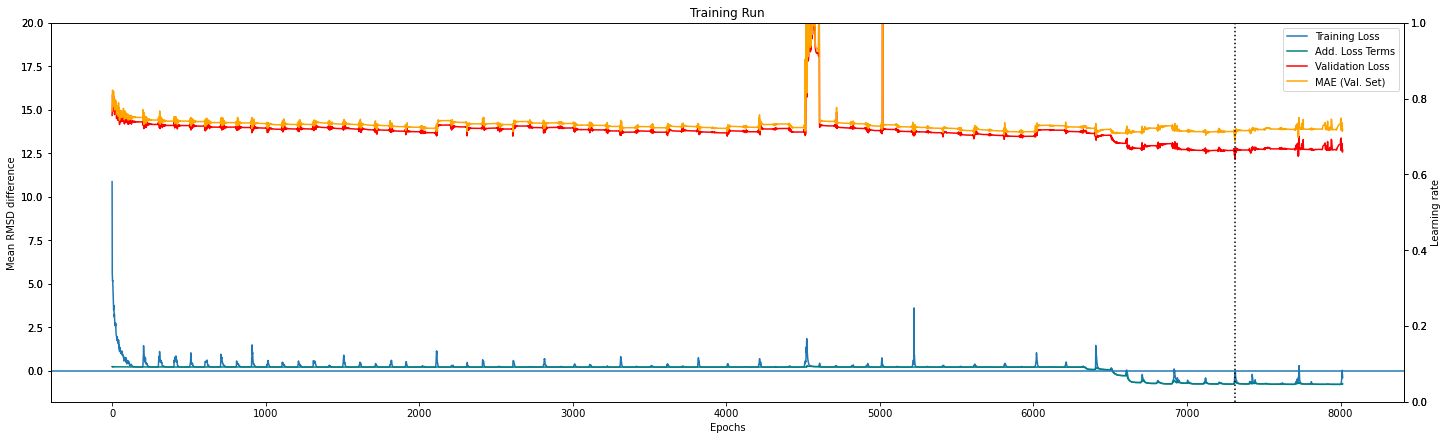

In [5]:
#plot the training run
select = 7314

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 7314
Test Set
Minimum Loss: Label = 25.5360, Prediction = 25.6884, Loss = 0.0116
Maximum Loss: Label = 0.0000, Prediction = 26.3361, Loss = 25.8361
Mean Test loss: 	 10.3419
Std. Dev. of Test loss:  6.1384
Min loss: 		 0.0116
First Quantile: 	 5.6692
Median: 		 9.6875
Third Quantile: 	 15.7851
Max Loss: 		 25.8361
LinregressResult(slope=0.6912012971460657, intercept=3.9287708670254293, rvalue=0.23429901687191373, pvalue=8.25698491033798e-05, stderr=0.17294480666755618, intercept_stderr=3.3076920416682514)


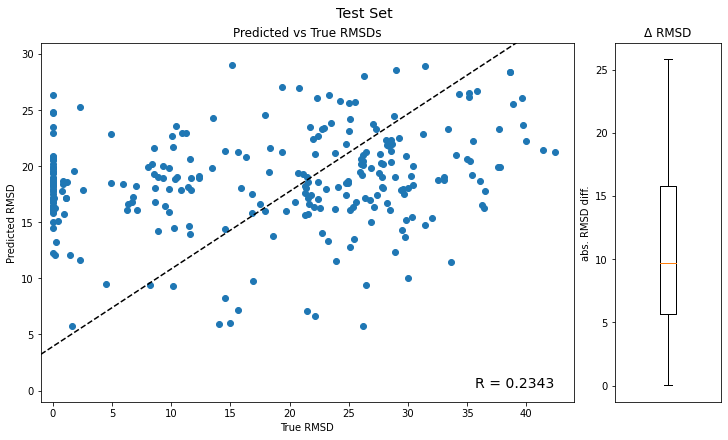

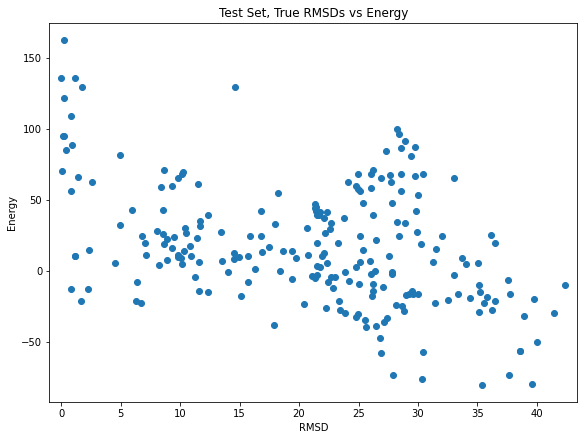

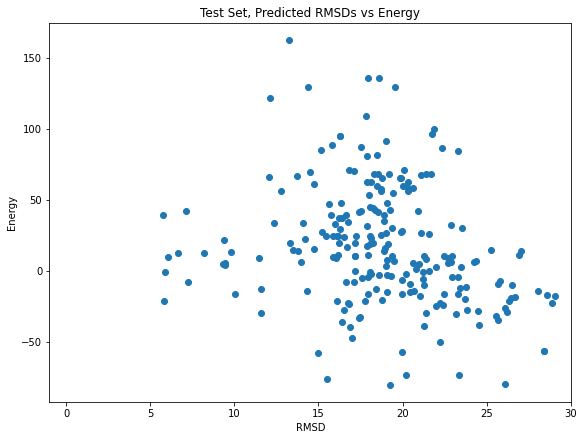

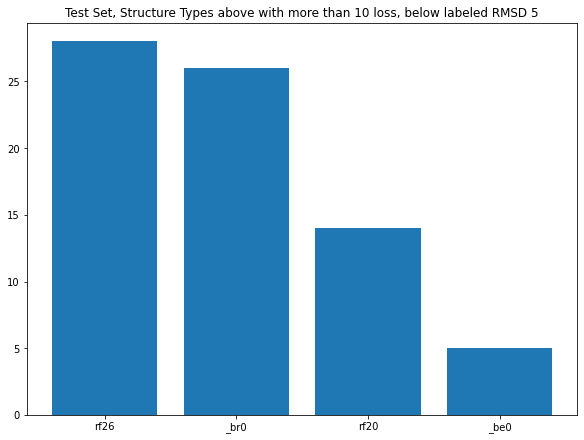

5S and tRNA Test Set
Minimum Loss: Label = 4.4320, Prediction = 4.4191, Loss = 0.0001
Maximum Loss: Label = 0.0000, Prediction = 28.7863, Loss = 28.2863
Mean Test loss: 	 4.0047
Std. Dev. of Test loss:  4.4676
Min loss: 		 0.0001
First Quantile: 	 0.9641
Median: 		 2.6675
Third Quantile: 	 5.4807
Max Loss: 		 28.2863
LinregressResult(slope=0.8557971127912638, intercept=1.3222984025231401, rvalue=0.7251257925641988, pvalue=2.386159775145265e-177, stderr=0.02471849335829443, intercept_stderr=0.4605156902571803)


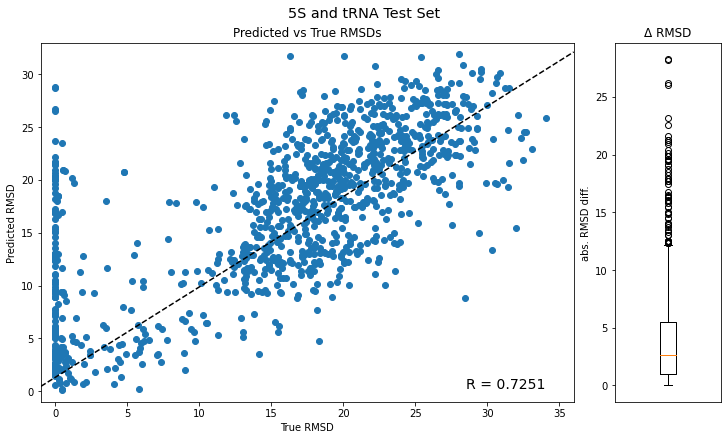

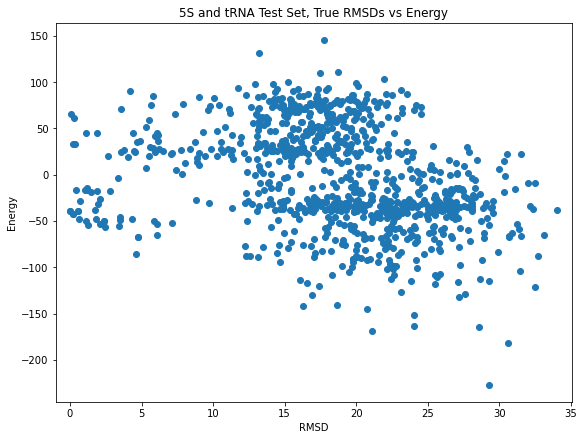

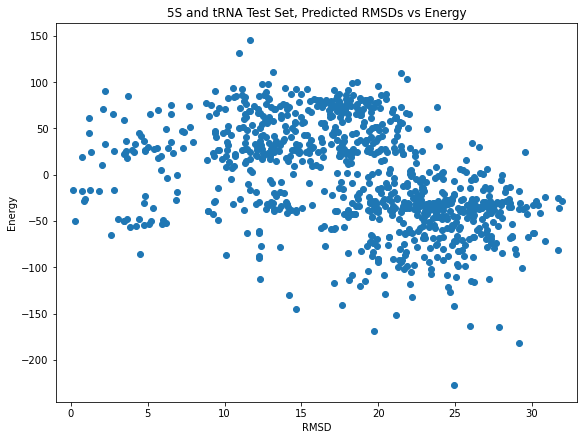

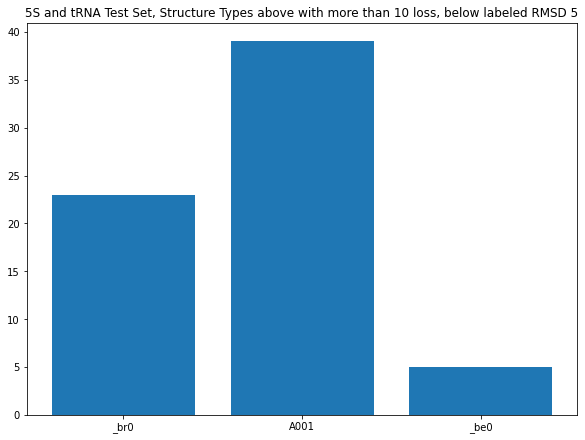

Prediction below 0: Label 0.0000, Pred -0.4103
Prediction below 0: Label 0.3100, Pred -0.0190
Prediction below 0: Label 0.3100, Pred -0.0190
Prediction below 0: Label 0.2590, Pred -0.1681
Prediction below 0: Label 0.0870, Pred -0.5610
Prediction below 0: Label 0.3100, Pred -0.0190
Prediction below 0: Label 0.0950, Pred -0.5281
Prediction below 0: Label 0.0000, Pred -0.4103
Prediction below 0: Label 0.3100, Pred -0.0190
Prediction below 0: Label 0.0900, Pred -0.5608
Prediction below 0: Label 1.4430, Pred -0.0158
Training Set
Minimum Loss: Label = 12.5080, Prediction = 12.5083, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 17.6019, Loss = 17.1019
Mean Test loss: 	 0.5679
Std. Dev. of Test loss:  1.3502
Min loss: 		 0.0000
First Quantile: 	 0.0314
Median: 		 0.1545
Third Quantile: 	 0.6307
Max Loss: 		 17.1019
LinregressResult(slope=0.9857438055713746, intercept=0.6035902170123926, rvalue=0.9838193897727002, pvalue=0.0, stderr=0.0065202251059271795, intercept_stderr=0.129056922

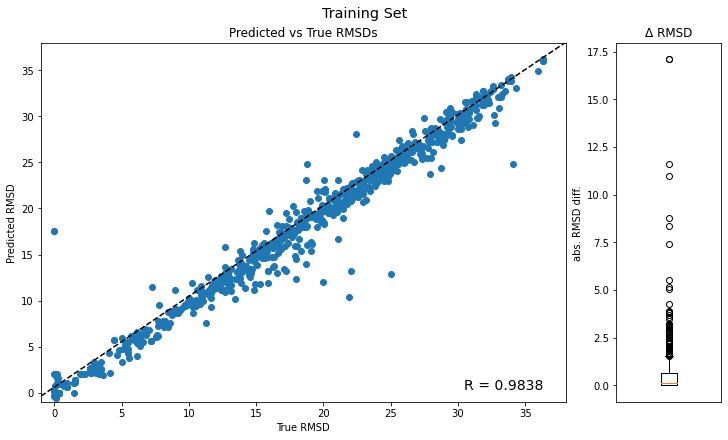

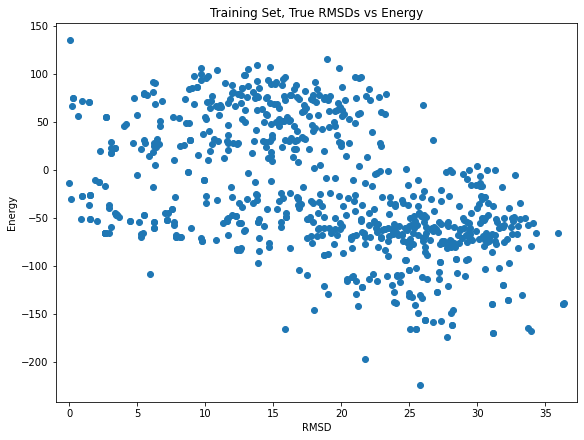

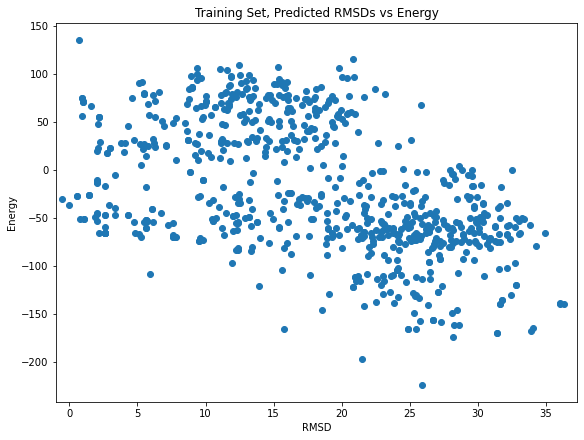

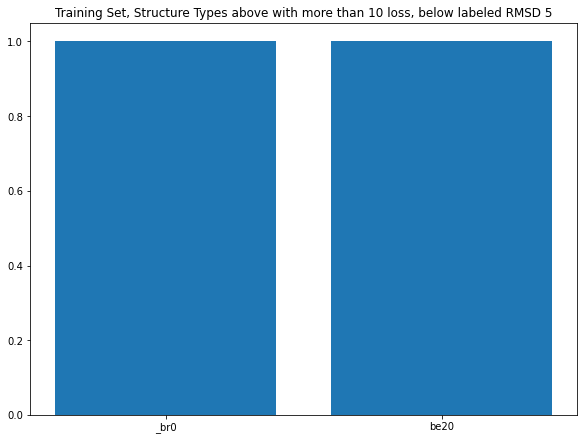

Validation Set
Minimum Loss: Label = 27.7030, Prediction = 27.6534, Loss = 0.0012
Maximum Loss: Label = 61.9850, Prediction = 12.8863, Loss = 48.5987
Mean Test loss: 	 12.7972
Std. Dev. of Test loss:  9.3355
Min loss: 		 0.0012
First Quantile: 	 4.6236
Median: 		 12.2126
Third Quantile: 	 18.9571
Max Loss: 		 48.5987
LinregressResult(slope=0.5561332046927993, intercept=12.051223418198012, rvalue=0.18216801184833611, pvalue=0.0002682501210861341, stderr=0.15122731623911642, intercept_stderr=3.145969769266103)


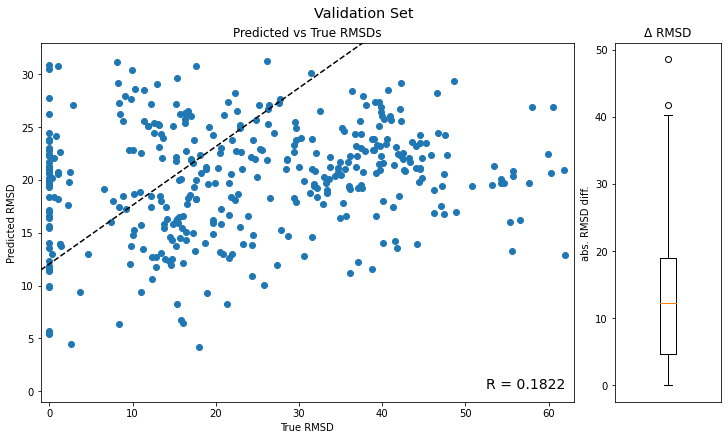

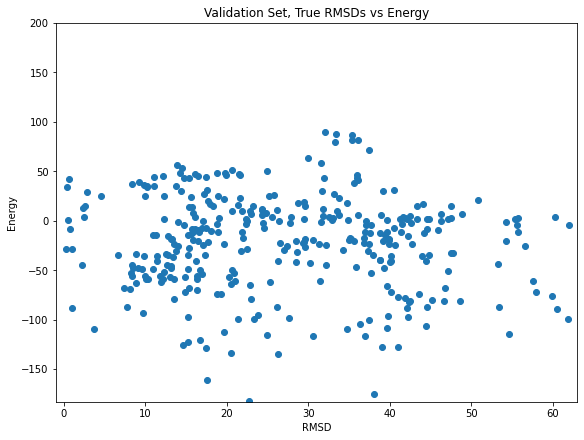

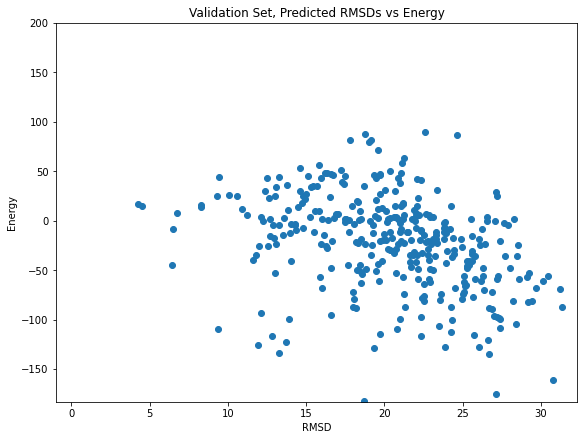

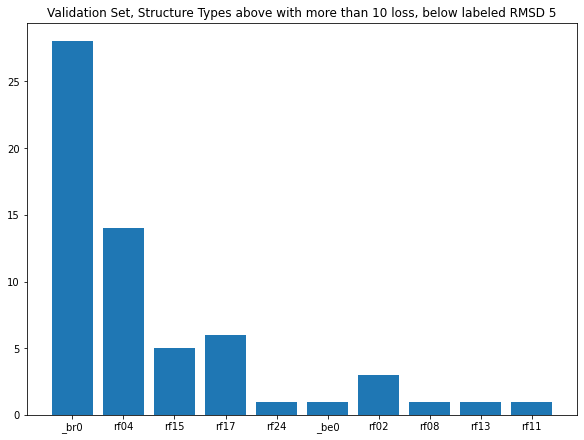

LinregressResult(slope=0.7196665175015147, intercept=7.209507326403701, rvalue=0.43724446885579754, pvalue=1.1697906687060128e-70, stderr=0.03836055072081165, intercept_stderr=0.762705090530787)


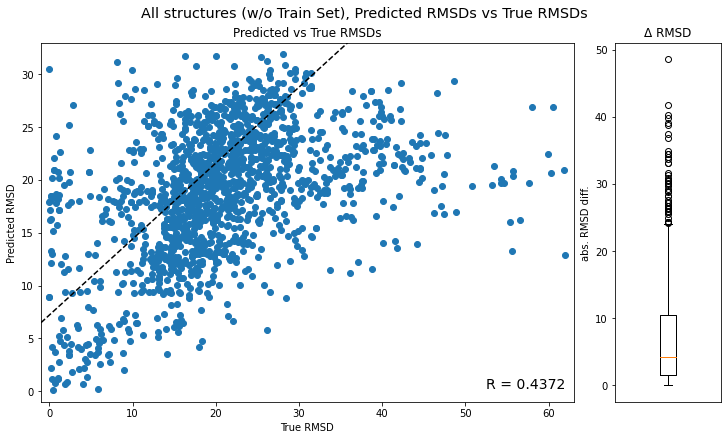

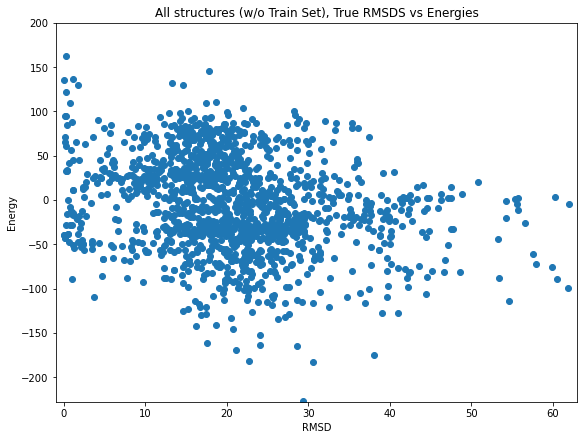

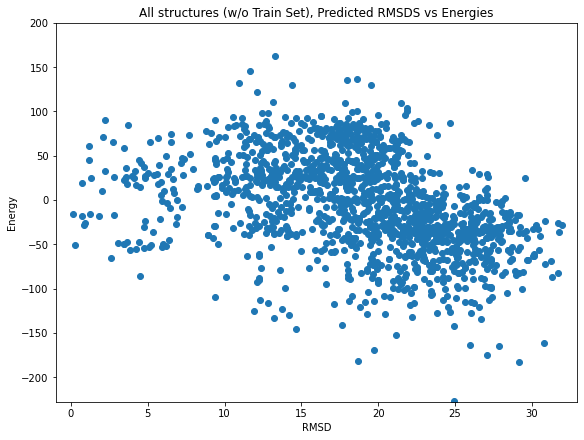

In [6]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9828514020063042, intercept=0.07323626732441468, rvalue=0.9469904330892006, pvalue=1.234775984829401e-137, stderr=0.020106429702163028, intercept_stderr=0.3845497243371475)


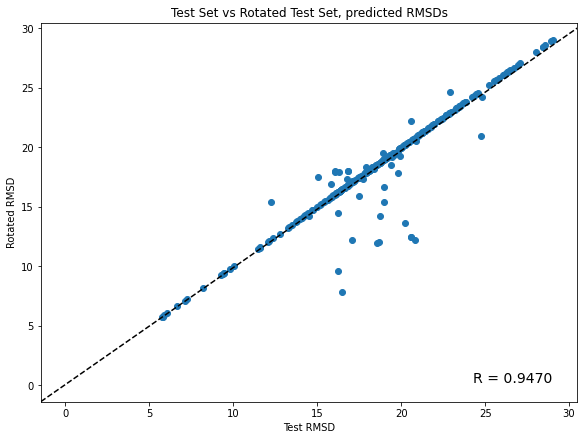

LinregressResult(slope=0.9406719477654748, intercept=0.36710846424703547, rvalue=0.972641780511971, pvalue=2.3043284506986722e-176, stderr=0.013548367028919872, intercept_stderr=0.16293828616836636)


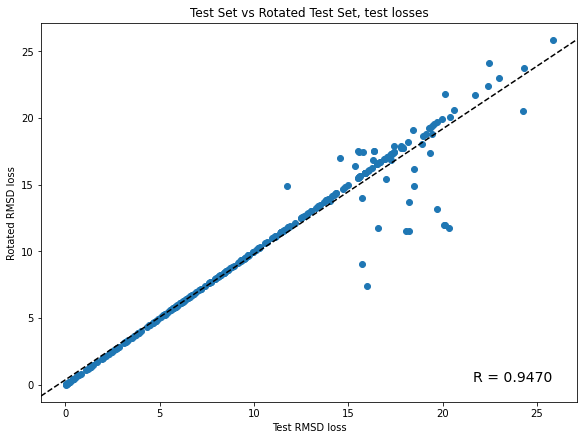

LinregressResult(slope=0.9592616877436707, intercept=0.7938798195078398, rvalue=0.9639559877443068, pvalue=0.0, stderr=0.008052847725242675, intercept_stderr=0.15002786232878168)


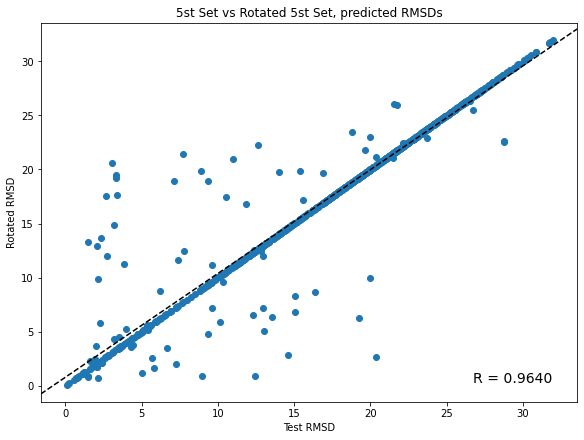

LinregressResult(slope=0.9462004291990882, intercept=0.3157197604752935, rvalue=0.903026929840088, pvalue=0.0, stderr=0.013690447104466449, intercept_stderr=0.08213850545470663)


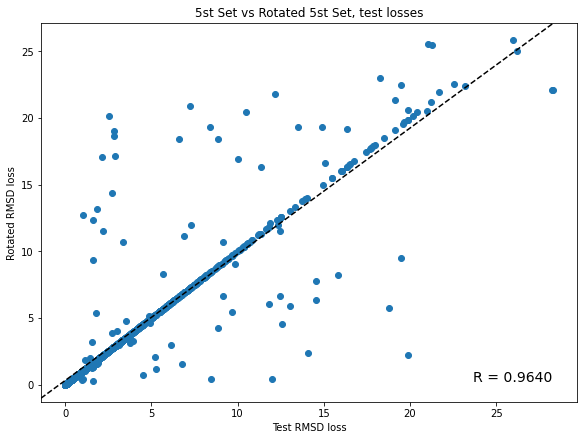

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")